# BGL Log Anomaly Detection Project

This notebook implements a comprehensive log anomaly detection pipeline for the BlueGene/L (BGL) supercomputer log dataset. The workflow includes:
1. Data loading and preprocessing
2. Log parsing and template extraction using Drain3
3. Feature engineering
4. Deep learning model training with LSTM

---

## Step 1: Import Required Libraries

This cell imports all necessary libraries for data processing, log parsing, machine learning, and visualization.


In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from drain3 import TemplateMiner
from drain3.template_miner_config import TemplateMinerConfig
from drain3.file_persistence import FilePersistence
import json
import pandas as pd
import re
from datetime import datetime

## Step 2: Define Data Path

This cell sets the path to the BGL structured log file. The file contains preprocessed log entries with structured information including labels, timestamps, components, and log content.


In [9]:
DATA_PATH = os.getcwd() + "/data/BGL_2k.log_structured.csv"

## Step 3: Load and Inspect Data

This cell loads the structured BGL log data from the CSV file and displays the first few rows to understand the data structure. The dataset contains log entries with various attributes like LineId, Label, Timestamp, Date, Time, Node, Type, Component, Level, Content, EventId, and EventTemplate.


In [10]:
BGL_structured_df = pd.read_csv(DATA_PATH, encoding='utf-8')
BGL_structured_df.head()

,LineId,Label,Timestamp,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate
0,1,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,E77,instruction cache parity error corrected
1,2,-,1117838573,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.53.276129,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,E77,instruction cache parity error corrected
2,3,-,1117838976,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.49.36.156884,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,E77,instruction cache parity error corrected
3,4,-,1117838978,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.49.38.026704,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,E77,instruction cache parity error corrected
4,5,-,1117842440,2005.06.03,R23-M0-NE-C:J05-U01,2005-06-03-16.47.20.730545,R23-M0-NE-C:J05-U01,RAS,KERNEL,INFO,63543 double-hummer alignment exceptions,E3,<*> double-hummer alignment exceptions


## Step 4: Analyze Label Distribution

This cell counts the number of unique labels in the dataset and displays the distribution of each label. Labels represent different types of log events (normal vs. anomalous). Understanding the label distribution helps assess class imbalance in the dataset.


In [11]:
label_counts = BGL_structured_df['Label'].nunique()

print(f'Total unique labels in the data: {label_counts}')
BGL_structured_df['Label'].value_counts()

Total unique labels in the data: 13


Label
-           1857
KERNDTLB      60
KERNSTOR      30
APPSEV        17
KERNMNTF      11
KERNTERM       7
KERNREC        5
APPRES         4
APPREAD        3
APPTO          2
KERNRTSP       2
APPCHILD       1
APPOUT         1
Name: count, dtype: int64

## Step 5: Filter Labels by Frequency

This cell filters the dataset to keep only labels that appear at least 40 times. This helps remove rare labels that may not have sufficient data for reliable model training, reducing noise and improving model performance on the most common log patterns.


In [12]:
label_vale_counts = BGL_structured_df['Label'].value_counts()
valid_labels = label_vale_counts[label_vale_counts >= 40].index
BGL_structured_df = BGL_structured_df[BGL_structured_df['Label'].isin(valid_labels)].copy()

## Step 6: Analyze Type Distribution

This cell counts and displays the distribution of log types in the filtered dataset. The "Type" field categorizes log entries (e.g., "RAS" - Reliability, Availability, Serviceability logs).


In [13]:
type_counts = BGL_structured_df['Type'].nunique()

print(f'Total unique type names in the data: {type_counts}')
BGL_structured_df['Type'].value_counts()

Total unique type names in the data: 1


Type
RAS    1879
Name: count, dtype: int64

## Step 7: Filter Types by Frequency

This cell filters the dataset to keep only log types that appear at least 5 times. Similar to label filtering, this ensures we have sufficient data for each type category.


In [14]:
type_vale_counts = BGL_structured_df['Type'].value_counts()
valid_types = type_vale_counts[type_vale_counts >= 5].index
BGL_structured_df = BGL_structured_df[BGL_structured_df['Type'].isin(valid_types)].copy()

## Step 8: Analyze Component Distribution

This cell counts and displays the distribution of system components in the log data. Components represent different parts of the system that generate logs (e.g., APP, KERNEL, MMCS - Memory Management Control System).


In [15]:
component_counts = BGL_structured_df['Component'].nunique()

print(f'Total unique Components in the data: {component_counts}')
BGL_structured_df['Component'].value_counts()

Total unique Components in the data: 3


Component
KERNEL    1765
APP         79
MMCS        35
Name: count, dtype: int64

## Step 9: Filter Components by Frequency

This cell filters the dataset to keep only components that appear at least 5 times, ensuring sufficient representation for each component category.


In [16]:
component_vale_counts = BGL_structured_df['Component'].value_counts()
valid_components = component_vale_counts[component_vale_counts >= 5].index
BGL_structured_df = BGL_structured_df[BGL_structured_df['Component'].isin(valid_components)].copy()

## Step 10: Analyze Log Level Distribution

This cell counts and displays the distribution of log levels (e.g., INFO, ERROR, FATAL, WARNING). Log levels indicate the severity of the logged event.


In [17]:
level_counts = BGL_structured_df['Level'].nunique()

print(f'Total unique levels in the data: {level_counts}')
BGL_structured_df['Level'].value_counts()

Total unique levels in the data: 3


Level
INFO     1580
FATAL     264
ERROR      35
Name: count, dtype: int64

## Step 11: Filter Log Levels by Frequency

This cell filters the dataset to keep only log levels that appear at least 5 times, maintaining consistency in the filtering approach across all categorical features.


In [18]:
level_vale_counts = BGL_structured_df['Level'].value_counts()
valid_levels = level_vale_counts[level_vale_counts >= 5].index
BGL_structured_df = BGL_structured_df[BGL_structured_df['Level'].isin(valid_levels)].copy()

## Step 12: Inspect Dataset Information

This cell displays comprehensive information about the filtered dataset including:
- Data types of each column
- Number of non-null values
- Memory usage
- Total number of entries after filtering

This helps verify the data quality and understand what columns are available for feature engineering.


In [19]:
BGL_structured_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1879 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LineId         1879 non-null   int64 
 1   Label          1879 non-null   object
 2   Timestamp      1879 non-null   int64 
 3   Date           1879 non-null   object
 4   Node           1844 non-null   object
 5   Time           1879 non-null   object
 6   NodeRepeat     1844 non-null   object
 7   Type           1879 non-null   object
 8   Component      1879 non-null   object
 9   Level          1879 non-null   object
 10  Content        1879 non-null   object
 11  EventId        1879 non-null   object
 12  EventTemplate  1879 non-null   object
dtypes: int64(2), object(11)
memory usage: 205.5+ KB


## Step 13: Check for Missing Values

This cell identifies columns with missing (NaN) values in the dataset. Understanding missing data patterns is crucial for data cleaning and feature engineering decisions.


In [20]:
BGL_structured_df.isna().sum()

LineId            0
Label             0
Timestamp         0
Date              0
Node             35
Time              0
NodeRepeat       35
Type              0
Component         0
Level             0
Content           0
EventId           0
EventTemplate     0
dtype: int64

## Step 14: Remove Columns with Missing Values

This cell removes the 'Node' and 'NodeRepeat' columns from the dataset because they contain missing values. These columns are not essential for the anomaly detection task, so removing them simplifies the dataset without losing critical information.


In [21]:
BGL_structured_df.drop(columns=['Node', 'NodeRepeat'], inplace=True)

## Step 15: Verify No Remaining Missing Values

This cell checks if there are any remaining null/missing values in the dataset after cleaning. A return value of False confirms the dataset is clean and ready for further processing.


In [22]:
BGL_structured_df.isnull().values.any()

np.False_

## Step 16: Display Dataset Dimensions and Columns

This cell prints the final shape of the dataset (number of rows and columns) and lists all remaining column names. This provides a summary of the cleaned dataset structure.


In [23]:
rows, columns = BGL_structured_df.shape
print(f"Rows: {rows}, Columns: {columns}")

column_names_list = BGL_structured_df.columns.tolist()
print("Column Names:", column_names_list)

Rows: 1879, Columns: 11
Column Names: ['LineId', 'Label', 'Timestamp', 'Date', 'Time', 'Type', 'Component', 'Level', 'Content', 'EventId', 'EventTemplate']


## Step 17: Sample Data Preview

This cell displays a random sample of 5 rows from the cleaned dataset, allowing visual inspection of the data to ensure preprocessing steps were applied correctly.


In [24]:
BGL_structured_df.sample(5)

,LineId,Label,Timestamp,Date,Time,Type,Component,Level,Content,EventId,EventTemplate
308,309,-,1118773862,2005.06.14,2005-06-14-11.31.02.213030,RAS,KERNEL,FATAL,core configuration register: 0x00002000,E43,core configuration register: <*>
1316,1317,-,1125084423,2005.08.26,2005-08-26-12.27.03.476538,RAS,KERNEL,INFO,1524480 double-hummer alignment exceptions,E3,<*> double-hummer alignment exceptions
1714,1715,-,1131477559,2005.11.08,2005-11-08-11.19.19.457791,RAS,KERNEL,INFO,iar 00106200 dear 0247019c,E70,iar <*> dear <*>
336,337,-,1118911785,2005.06.16,2005-06-16-01.49.45.558500,RAS,KERNEL,INFO,generating core.2961,E67,generating core.<*>
1962,1963,-,1134130421,2005.12.09,2005-12-09-04.13.41.810977,RAS,KERNEL,INFO,total of 5 ddr error(s) detected and corrected...,E119,total of <*> ddr error(s) detected and correct...


## Step 18: Create Visualization Function

This cell defines a reusable function `plot_categorical_distribution()` for visualizing the distribution of categorical variables in the dataset. The function supports both bar charts and pie charts, with customizable styling options. This utility function will be used to visualize the distribution of labels, types, components, and log levels.


In [25]:
def plot_categorical_distribution(df, column, plot_type='bar', title=None, xlabel=None, ylabel='Count', figsize=(10, 6), palette='viridis'):
    """
    Plots the distribution of a categorical column in a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        column (str): The name of the categorical column to plot.
        plot_type (str): Type of plot - 'bar' or 'pie' (default: 'bar').
        title (str, optional): Title of the plot.
        xlabel (str, optional): Label for the x-axis.
        ylabel (str): Label for the y-axis (default: 'Count').
        figsize (tuple): Figure size (default: (10, 6)).
        palette (str): Color palette for the bars (default: 'viridis').

    Returns:
        None
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame")

    value_counts = df[column].value_counts()

    plt.figure(figsize=figsize)

    if plot_type == 'bar':
        sns.countplot(x=column, data=df, palette=palette)
        plt.xlabel(xlabel if xlabel else column)
        plt.ylabel(ylabel)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    elif plot_type == 'pie':
        plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=sns.color_palette(palette, len(value_counts)))
        plt.ylabel('')
    else:
        raise ValueError("Invalid plot type. Choose either 'bar' or 'pie'.")

    plt.title(title if title else f'Distribution of {column}')
    plt.xticks(rotation=45) if plot_type == 'bar' else None
    plt.show()

## Step 19: Visualize Label Distribution

This cell creates a bar chart showing the distribution of log labels in the filtered dataset. This visualization helps understand class balance and identify the most common types of log events (normal vs. anomalous).


C:\Users\govel\AppData\Local\Temp\ipykernel_13120\2618730542.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette=palette)


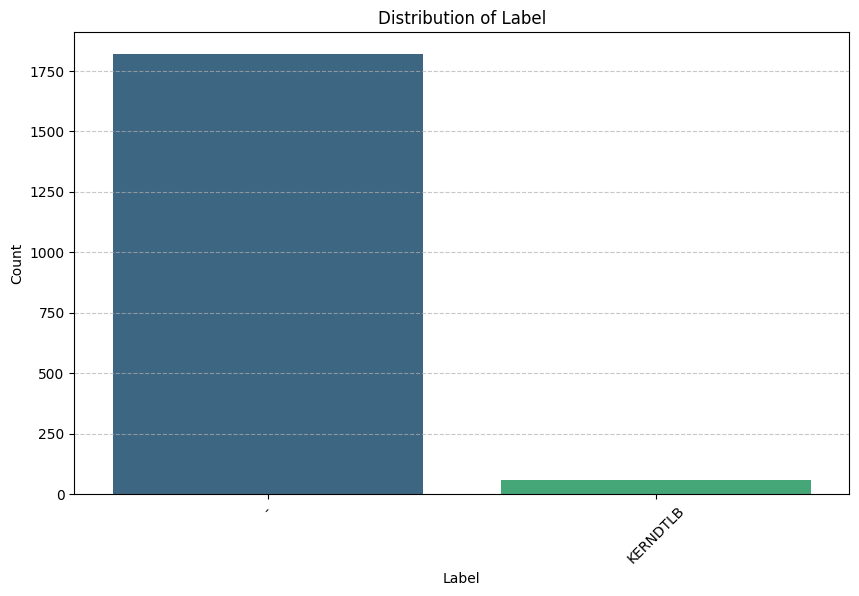

In [26]:
plot_categorical_distribution(BGL_structured_df, 'Label')

## Step 20: Visualize Type Distribution

This cell creates a pie chart showing the proportional distribution of log types. A pie chart is useful here since there's typically only one type in the filtered dataset (RAS logs), making it easy to see the composition.


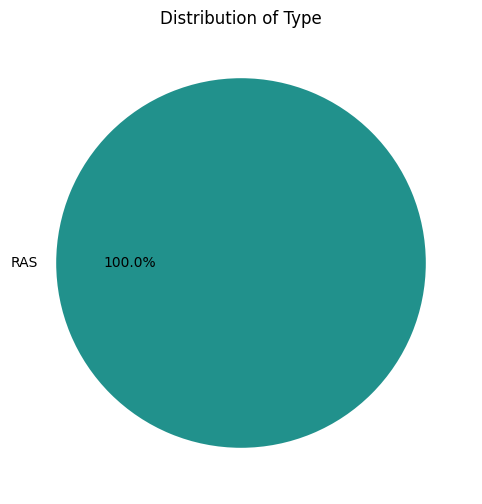

In [27]:
plot_categorical_distribution(BGL_structured_df, 'Type', plot_type='pie')

## Step 21: Visualize Component Distribution

This cell creates a bar chart showing the distribution of system components. Understanding which components generate the most logs can help identify critical system areas that need closer monitoring.


C:\Users\govel\AppData\Local\Temp\ipykernel_13120\2618730542.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette=palette)


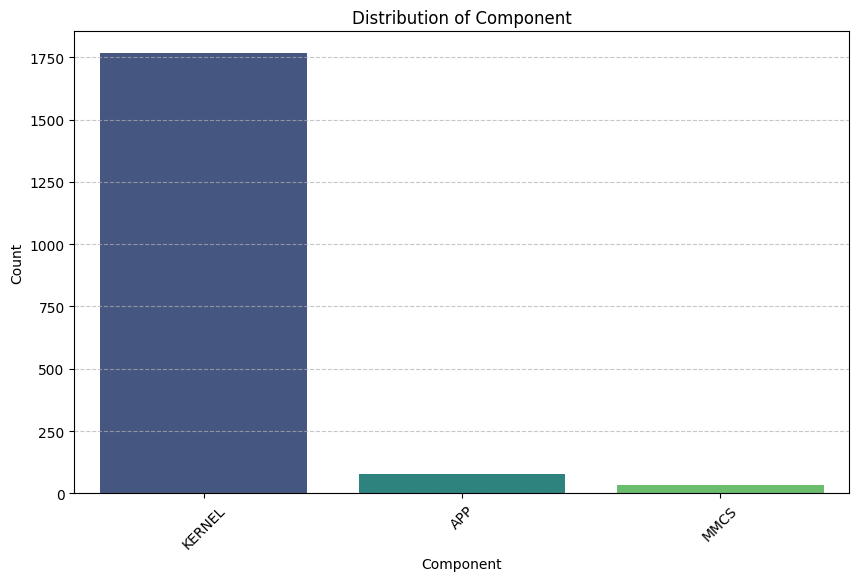

In [28]:
plot_categorical_distribution(BGL_structured_df, 'Component')

## Step 22: Visualize Log Level Distribution

This cell creates a bar chart showing the distribution of log levels (INFO, ERROR, FATAL). This visualization helps assess the severity distribution of log entries, which is important for anomaly detection as errors and fatal messages are more likely to be anomalous.


C:\Users\govel\AppData\Local\Temp\ipykernel_13120\2618730542.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette=palette)


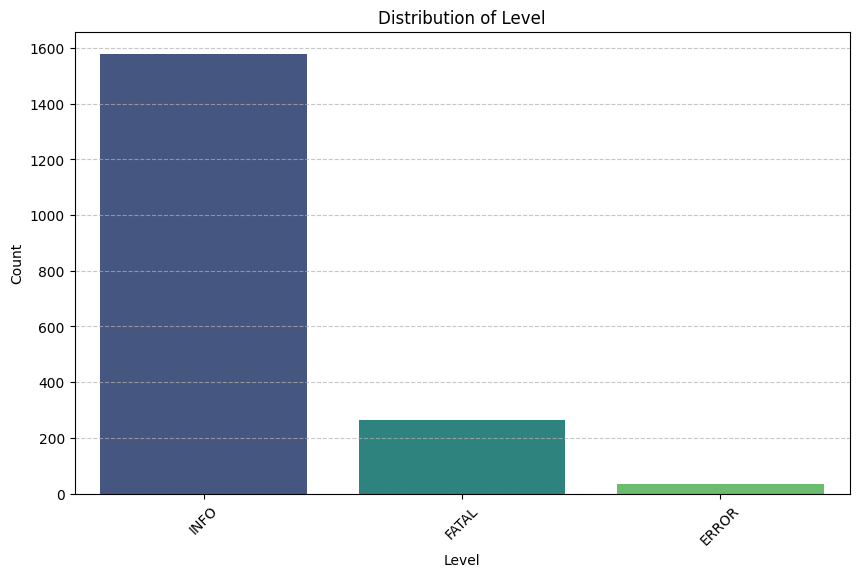

In [29]:
plot_categorical_distribution(BGL_structured_df, 'Level')

## Step 23: Set Up Drain3 Log Parser

This cell configures and initializes the Drain3 log parsing system, which is a state-of-the-art log template mining tool. The process includes:

1. **Variable Masking**: Defines regex patterns to identify and mask variable parts of log messages (like IP addresses, hex numbers, block IDs, dates, times, etc.) by replacing them with `<*>`. This helps the parser focus on the structural pattern rather than variable values.

2. **Drain3 Configuration**: Sets up the template miner with parameters:
   - `drain_sim_th`: Similarity threshold (0.3) for matching log messages to templates
   - `drain_depth`: Maximum depth of the parse tree (8 levels)
   - `drain_max_children`: Maximum children per node (600)

3. **Persistence Handler**: Initializes file-based persistence to save the parsing state, allowing the parser to resume work if interrupted.

4. **Processing Function**: Defines `process_logs()` which:
   - Takes each log message from the Content column
   - Masks variables using the regex patterns
   - Feeds the masked message to Drain3 for template extraction
   - Returns a DataFrame with extracted EventTemplate and EventId columns
   - Handles errors gracefully by marking parsing failures

This is a critical step for log analysis as it converts raw, unstructured log messages into structured templates that can be used for pattern recognition and anomaly detection.


In [30]:
# Define regex patterns for variable masking
regex_patterns = [
    r'0x[0-9a-fA-F]+',                                      # Hexadecimal
    r'blk_(|-)[0-9]+',                                      # Block IDs
    r'(/|)([0-9]+\.){3}[0-9]+(:[0-9]+|)(:|)',              # IP addresses
    r'(?<=[^A-Za-z0-9])(\-?\+?\d+)(?=[^A-Za-z0-9])|[0-9]+$', # Numbers
    r'core\.[0-9]+',                                        # Core IDs
    r'node-[0-9]+',                                         # Node IDs
    r'[0-9]{4}-[0-9]{2}-[0-9]{2}',                         # Dates
    r'[0-9]{2}:[0-9]{2}:[0-9]{2}',                        # Times
    r'[0-9a-fA-F]+:[0-9a-fA-F]+',                          # Hex:Hex pattern
    r'fpr[0-9]+=[\w\d]+',                                   # fpr pattern
    r'[0-9a-fA-F]{6,}'                                    # Long hex numbers
]

def mask_variables(message):
    """
    Replace variables in the message with <*> using regex patterns
    """
    masked_message = message
    for pattern in regex_patterns:
        masked_message = re.sub(pattern, '<*>', masked_message)
    return masked_message

# Configure Drain3
config = TemplateMinerConfig()
config.load('drain3.ini')

# Additional configuration parameters
config.drain_sim_th = 0.3
config.drain_depth = 8
config.drain_max_children = 600

# Initialize persistence handler
persistence_handler = FilePersistence("drain3_state.bin")

# Initialize TemplateMiner
template_miner = TemplateMiner(persistence_handler, config)

def process_logs(df):
    """
    Process logs using Drain3 and return enhanced dataframe
    """
    templates = []
    template_ids = []
    parameters = []

    total_logs = len(df)

    # Process each log message with progress tracking
    for idx, content in enumerate(df['Content'], 1):
        try:
            # Handle potential NaN or invalid entries
            if pd.isna(content):
                content = "EMPTY_LOG"
            else:
                content = str(content).strip()

            # Mask variables before adding to template miner
            masked_content = mask_variables(content)

            # Add log message and get result
            result = template_miner.add_log_message(masked_content)

            # Print first few results to debug
            # if idx <= 5:
            #     print(f"\nDebug - Result for log {idx}:")
            #     print(f"Original: {content}")
            #     print(f"Masked: {masked_content}")
            #     print(f"Result: {result}")

            # Correctly access dictionary keys
            templates.append(result['template_mined'])
            template_ids.append(result['cluster_id'])
            parameters.append([])

            # Print progress every 10%
            if idx % (total_logs // 10) == 0:
                print(f"Processing: {idx/total_logs*100:.1f}% completed")

        except KeyError as e:
            print(f"\nKey Error in log {idx}:")
            print(f"Content: {content}")
            print(f"Masked content: {masked_content}")
            print(f"Result keys: {result.keys() if 'result' in locals() else 'No result'}")
            print(f"Error: {str(e)}")
            templates.append('PARSING_ERROR')
            template_ids.append(-1)
            parameters.append([])

        except Exception as e:
            print(f"\nUnexpected error in log {idx}:")
            print(f"Content: {content}")
            print(f"Error: {str(e)}")
            templates.append('PARSING_ERROR')
            template_ids.append(-1)
            parameters.append([])

    # Create a new DataFrame with original data and parsed templates
    result_df = df.copy()
    result_df['EventTemplate'] = templates
    result_df['EventId'] = template_ids
    result_df['Parameters'] = [json.dumps(p) for p in parameters]  # Convert parameters to JSON strings

    return result_df

config file not found: drain3.ini


## Step 24: Execute Log Parsing and Save Results

This cell executes the log parsing process on the entire dataset and saves the results:

1. **Process Logs**: Runs the Drain3 parser on all log entries, extracting unique templates from log messages
2. **Create Template Summary**: Generates a DataFrame with unique templates and their occurrence counts
3. **Save Results**: 
   - Saves unique templates to `BGL_unique_templates.csv`
   - Saves the complete parsed dataset with templates to `BGL_parsed_with_templates.csv`
4. **Display Statistics**: Shows:
   - Number of unique templates found
   - Total log entries processed
   - Top 5 most common templates
   - Compression ratio (how many log entries per template)
   - Parsing coverage (percentage of successfully parsed logs)

The compression ratio indicates how effectively the parser groups similar log messages together, which is essential for identifying patterns and anomalies.


In [31]:
try:
    print("\nStarting log parsing...")
    # Process the logs
    result_df = process_logs(BGL_structured_df)

    print("\nCreating unique templates dataframe...")
    # Create DataFrame with unique templates
    template_counts = result_df['EventTemplate'].value_counts()

    unique_templates_df = pd.DataFrame({
        'EventTemplate': template_counts.index,
        'Occurrences': template_counts.values
    })

    # Add EventId from the first occurrence of each template
    # unique_templates_df['EventId'] = [
    #     result_df[result_df['EventTemplate'] == template]['EventId'].iloc[0]
    #     for template in unique_templates_df['EventTemplate']
    # ]

    # Save unique templates
    print("\nSaving unique templates...")
    unique_templates_df.to_csv('BGL_unique_templates.csv', index=False)

    # Save the complete parsed dataset
    print("\nSaving parsed dataset...")
    result_df.to_csv('BGL_parsed_with_templates.csv', index=False)

    # Print statistics
    n_templates = len(unique_templates_df)
    print(f'\nParsing completed!')
    print(f'Number of unique templates: {n_templates}')
    print(f'Number of log entries: {len(BGL_structured_df)}')

    # Template statistics
    print('\nTop 5 most common templates:')
    print(unique_templates_df.nlargest(5, 'Occurrences')[['EventTemplate', 'Occurrences']])

    # Calculate parsing metrics
    compression_ratio = len(BGL_structured_df) / n_templates
    parsed_logs = len(result_df[result_df['EventTemplate'] != 'PARSING_ERROR'])
    coverage = (parsed_logs / len(BGL_structured_df)) * 100

    print(f'\nCompression ratio: {compression_ratio:.2f}')
    print(f'Parsing coverage: {coverage:.2f}%')

except Exception as e:
    print(f"\nAn error occurred in main execution:")
    print(f"Error: {str(e)}")
    raise


Starting log parsing...
Processing: 10.0% completed
Processing: 19.9% completed
Processing: 29.9% completed
Processing: 39.8% completed
Processing: 49.8% completed
Processing: 59.7% completed
Processing: 69.7% completed
Processing: 79.6% completed
Processing: 89.6% completed
Processing: 99.5% completed

Creating unique templates dataframe...

Saving unique templates...

Saving parsed dataset...

Parsing completed!
Number of unique templates: 115
Number of log entries: 1879

Top 5 most common templates:
                             EventTemplate  Occurrences
0                      generating core.<*>          721
1                         iar <*> dear <*>          207
2   <*> double-hummer alignment exceptions          108
3             CE sym <*>, at <*>, mask <*>           92
4  <*> floating point alignment exceptions           84

Compression ratio: 16.34
Parsing coverage: 100.00%


## Step 25: Update Dataset with Parsed Templates

This cell updates the main DataFrame with the EventTemplate column from the parsed results. This replaces any existing EventTemplate values with the templates extracted by Drain3, ensuring consistency across the dataset.


In [32]:
BGL_structured_df['EventTemplate'] = result_df['EventTemplate']

## Step 26: Remove Redundant Columns

This cell removes the 'Date', 'Time', and 'Content' columns from the dataset. The Date and Time columns are redundant since we have the Timestamp column, and the Content column is no longer needed after template extraction. This reduces dataset size and focuses on the features needed for modeling.


In [33]:
BGL_structured_df.drop(columns=['Date', 'Time', 'Content'], inplace=True)

## Step 27: Preview Dataset After Cleaning

This cell displays a random sample of the dataset after removing redundant columns to verify the changes were applied correctly.


In [34]:
BGL_structured_df.sample(5)

,LineId,Label,Timestamp,Type,Component,Level,EventId,EventTemplate
882,883,-,1121308677,RAS,KERNEL,INFO,E67,generating core.<*>
1135,1136,-,1122166538,RAS,KERNEL,INFO,E4,<*> floating point alignment exceptions
930,931,-,1121313817,RAS,KERNEL,INFO,E67,generating core.<*>
487,488,-,1120148424,RAS,KERNEL,INFO,E67,generating core.<*>
547,548,-,1120265568,RAS,KERNEL,INFO,E3,<*> double-hummer alignment exceptions


## Step 28: Extract Temporal Features

This cell extracts time-based features from the Timestamp column, which are important for anomaly detection as many anomalies occur at specific times or show temporal patterns:

- **Hour**: Hour of the day (0-23)
- **Minute**: Minute of the hour (0-59)
- **DayOfWeek**: Day of the week (0=Monday, 6=Sunday)
- **DayOfMonth**: Day of the month (1-31)
- **Month**: Month of the year (1-12)

These features help the model learn temporal patterns such as:
- Anomalies occurring more frequently at certain hours
- Day-of-week patterns in system behavior
- Monthly trends in log generation


In [35]:
BGL_structured_df['Timestamp'] = pd.to_datetime(BGL_structured_df['Timestamp'])

# Create temporal features
BGL_structured_df['Hour'] = BGL_structured_df['Timestamp'].dt.hour
BGL_structured_df['Minute'] = BGL_structured_df['Timestamp'].dt.minute
BGL_structured_df['DayOfWeek'] = BGL_structured_df['Timestamp'].dt.dayofweek
BGL_structured_df['DayOfMonth'] = BGL_structured_df['Timestamp'].dt.day
BGL_structured_df['Month'] = BGL_structured_df['Timestamp'].dt.month

## Step 29: Preview Dataset with Temporal Features

This cell displays a sample of the dataset after adding temporal features to verify they were created correctly.


In [36]:
BGL_structured_df.sample(5)

,LineId,Label,Timestamp,Type,Component,Level,EventId,EventTemplate,Hour,Minute,DayOfWeek,DayOfMonth,Month
113,114,KERNDTLB,1970-01-01 00:00:01.118539342,RAS,KERNEL,FATAL,E55,data TLB error interrupt,0,0,3,1,1
1052,1053,-,1970-01-01 00:00:01.121902797,RAS,KERNEL,INFO,E4,8 floating point alignment exceptions,0,0,3,1,1
1921,1922,-,1970-01-01 00:00:01.133455642,RAS,KERNEL,INFO,E7,0 microseconds spent in the rbs signal handler...,0,0,3,1,1
632,633,-,1970-01-01 00:00:01.120928332,RAS,KERNEL,INFO,E67,generating core.<*>,0,0,3,1,1
1724,1725,-,1970-01-01 00:00:01.131582323,RAS,KERNEL,INFO,E70,iar <*> dear <*>,0,0,3,1,1


## Step 30: Encode Categorical Features

This cell converts categorical text features into numerical values using Label Encoding:

- **Type**: Encoded as Type_encoded
- **Component**: Encoded as Component_encoded  
- **Level**: Encoded as Level_encoded

Label encoding assigns a unique integer to each category (e.g., APP=0, KERNEL=1, MMCS=2). This is necessary because machine learning models require numerical input. The encoders are stored in a dictionary so we can later decode predictions back to original category names if needed.

After encoding, the original categorical columns are dropped to avoid redundancy.


In [37]:
# Encode categorical columns
from sklearn.preprocessing import LabelEncoder

categorical_columns = ['Type', 'Component', 'Level']
encoders = {}

for column in categorical_columns:
    encoders[column] = LabelEncoder()
    BGL_structured_df[column + '_encoded'] = encoders[column].fit_transform(BGL_structured_df[column])

# Drop original categorical columns
BGL_structured_df = BGL_structured_df.drop(categorical_columns, axis=1)

## Step 31: Encode Target Variable (Labels)

This cell encodes the target variable (Label) separately using Label Encoding. The target variable indicates whether a log entry is normal or anomalous. Encoding it to numerical values (e.g., '-'=0, 'KERNDTLB'=1) allows the model to learn classification patterns.

The label encoder is kept separate from feature encoders because it's used for the target variable, which has different semantics than input features.


In [38]:
# Encode target separately
label_encoder = LabelEncoder()
BGL_structured_df['Label_encoded'] = label_encoder.fit_transform(BGL_structured_df['Label'])

## Step 32: Remove Original Label Column

This cell removes the original text-based Label column since we now have the encoded version (Label_encoded) that will be used as the target variable for model training.


In [39]:
BGL_structured_df = BGL_structured_df.drop(['Label'], axis=1)

## Step 33: Preview Final Dataset Structure

This cell displays the first few rows of the dataset after all encoding and cleaning steps to verify the final structure before feature engineering.


In [40]:
BGL_structured_df.head()

,LineId,Timestamp,EventId,EventTemplate,Hour,Minute,DayOfWeek,DayOfMonth,Month,Type_encoded,Component_encoded,Level_encoded,Label_encoded
0,1,1970-01-01 00:00:01.117838570,E77,instruction cache parity error corrected,0,0,3,1,1,0,1,2,0
1,2,1970-01-01 00:00:01.117838573,E77,instruction cache parity error corrected,0,0,3,1,1,0,1,2,0
2,3,1970-01-01 00:00:01.117838976,E77,instruction cache parity error corrected,0,0,3,1,1,0,1,2,0
3,4,1970-01-01 00:00:01.117838978,E77,instruction cache parity error corrected,0,0,3,1,1,0,1,2,0
4,5,1970-01-01 00:00:01.117842440,E3,63543 double-hummer alignment exceptions,0,0,3,1,1,0,1,2,0


## Step 34: Calculate Time-Based Feature - Inter-Event Time

This cell calculates `TimeSinceLastEvent`, which measures the time (in seconds) between consecutive log entries. This feature is important for anomaly detection because:
- Anomalies often occur in bursts (short inter-event times)
- Sudden changes in event frequency may indicate issues
- Normal system behavior has predictable timing patterns

The first row will have NaN since there's no previous event, which will be handled later.


In [41]:
BGL_structured_df['TimeSinceLastEvent'] = BGL_structured_df['Timestamp'].diff().dt.total_seconds()

## Step 35: Display Encoding Mappings

This cell prints the mapping between original categorical values and their encoded numerical values. This information is crucial for:
- Understanding model predictions (decoding predictions back to original categories)
- Interpreting feature importance
- Debugging model behavior
- Documenting the preprocessing pipeline

The output shows how each category in Type, Component, and Level was encoded.


In [42]:
# Print encoding information
print("\nEncoding Information:")
for column in categorical_columns:
    print(f"\n{column} encoding mapping:")
    for original, encoded in zip(encoders[column].classes_, range(len(encoders[column].classes_))):
        print(f"{original} -> {encoded}")


Encoding Information:

Type encoding mapping:
RAS -> 0

Component encoding mapping:
APP -> 0
KERNEL -> 1
MMCS -> 2

Level encoding mapping:
ERROR -> 0
FATAL -> 1
INFO -> 2


## Step 36: Display Label Encoding Mappings

This cell prints the mapping for the target variable (Label) encoding. This shows how normal ('-') and anomalous labels (like 'KERNDTLB') are represented numerically for model training and prediction.


In [43]:
print("\nLabel encoding mapping:")
for original, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{original} -> {encoded}")


Label encoding mapping:
- -> 0
KERNDTLB -> 1


## Step 37: Calculate Rolling Window Statistics

This cell calculates `EventsLastHour`, which counts the number of log events that occurred in the previous hour using a rolling window. This feature helps identify:
- Event bursts that may indicate anomalies
- Normal vs. abnormal event frequency patterns
- Temporal clustering of log entries

The rolling window approach provides a time-aware feature that considers the temporal context of events, which is important for sequence-based anomaly detection.


In [44]:
# Create time windows for event counting
window_size = '1H'  # 1 hour window
BGL_structured_df['EventsLastHour'] = BGL_structured_df.rolling(window=window_size, on='Timestamp').count()['EventTemplate']

C:\Users\govel\AppData\Local\Temp\ipykernel_13120\3054675042.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  BGL_structured_df['EventsLastHour'] = BGL_structured_df.rolling(window=window_size, on='Timestamp').count()['EventTemplate']


## Step 38: Calculate Component-Specific Features

This cell creates two component-specific time-based features:

1. **EventsPerComponent**: Total count of events per component across the entire dataset. This helps identify which components are more active.

2. **TimeSinceLastComponentEvent**: Time elapsed since the last event from the same component. This feature captures component-specific timing patterns and can help detect when a component stops generating logs (which might indicate a failure) or generates logs unusually frequently.

These features add component-level context to the temporal features, providing richer information for anomaly detection.


In [45]:
# Time-based features for each component
BGL_structured_df['EventsPerComponent'] = BGL_structured_df.groupby('Component_encoded')['Timestamp'].transform('count')
BGL_structured_df['TimeSinceLastComponentEvent'] = BGL_structured_df.groupby('Component_encoded')['Timestamp'].transform(lambda x: x.diff().dt.total_seconds())

## Step 39: Preview Dataset with All Engineered Features

This cell displays a sample of the dataset with all engineered features to verify they were calculated correctly before proceeding to feature matrix creation.


In [46]:
BGL_structured_df.sample(5)

,LineId,Timestamp,EventId,EventTemplate,Hour,Minute,DayOfWeek,DayOfMonth,Month,Type_encoded,Component_encoded,Level_encoded,Label_encoded,TimeSinceLastEvent,EventsLastHour,EventsPerComponent,TimeSinceLastComponentEvent
155,156,1970-01-01 00:00:01.118554603,E55,data TLB error interrupt,0,0,3,1,1,0,1,1,1,4.070000e-07,154.0,1765,4.070000e-07
73,74,1970-01-01 00:00:01.118149570,E67,generating core.<*>,0,0,3,1,1,0,1,2,0,1.000000e-09,72.0,1765,1.000000e-09
1210,1211,1970-01-01 00:00:01.123110774,E74,idoproxydb hit ASSERT condition: ASSERT expres...,0,0,3,1,1,0,2,0,0,2.000000e-08,1162.0,35,2.000000e-08
202,203,1970-01-01 00:00:01.118766833,E76,instruction address: <*>,0,0,3,1,1,0,1,1,0,6.940000e-07,184.0,1765,6.940000e-07
1985,1986,1970-01-01 00:00:01.134954903,E119,total of <*> ddr error(s) detected and correct...,0,0,3,1,1,0,1,2,0,2.544700e-05,1865.0,1765,2.544700e-05


## Step 40: Prepare Feature Matrix

This cell selects all the engineered numerical and categorical features to create the feature matrix (X) and extracts the encoded labels as the target variable (y). 

The feature columns include:
- Encoded categorical features (Type, Component, Level)
- Temporal features (Hour, Minute, DayOfWeek, DayOfMonth, Month)
- Time-based statistical features (TimeSinceLastEvent, EventsLastHour, EventsPerComponent, TimeSinceLastComponentEvent)

The EventTemplate column is excluded here but will be incorporated using text vectorization in the next step, as it requires different preprocessing.


In [47]:
# Prepare final feature matrix (excluding EventTemplate)
feature_columns = [
    'Type_encoded', 'Component_encoded', 'Level_encoded',
    'Hour', 'Minute', 'DayOfWeek', 'DayOfMonth', 'Month',
    'TimeSinceLastEvent', 'EventsLastHour',
    'EventsPerComponent', 'TimeSinceLastComponentEvent'
]

# Create final feature matrix and target vector
X = BGL_structured_df[feature_columns]
y = BGL_structured_df['Label_encoded']

## Step 41: Apply TF-IDF Vectorization to Log Templates

This cell processes the EventTemplate text data using TF-IDF (Term Frequency-Inverse Document Frequency) vectorization, which converts text templates into numerical features:

1. **TF-IDF Vectorizer Setup**: 
   - `max_features=100`: Limits to top 100 most important words/bigrams
   - `min_df=5`: Ignores terms that appear in fewer than 5 documents
   - `max_df=0.95`: Ignores terms that appear in more than 95% of documents (common stopwords)
   - `ngram_range=(1,2)`: Uses both single words (unigrams) and word pairs (bigrams)
   - `stop_words='english'`: Removes common English stopwords

2. **Vectorization**: Transforms EventTemplate strings into sparse numerical vectors representing word importance

3. **Feature Combination**: Combines the numerical/categorical features (X) with the text features (template_vectors) using sparse matrix operations for efficiency

4. **Data Cleaning**: Handles any remaining NaN values by filling with 0, ensuring the final feature matrix is complete

The resulting combined feature matrix contains both structured numerical features and text-derived features, providing a comprehensive representation for the anomaly detection model.


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=100,          # Limit number of features (adjust as needed)
    min_df=5,                  # Minimum document frequency
    max_df=0.95,              # Maximum document frequency
    ngram_range=(1, 2),       # Use both unigrams and bigrams
    stop_words='english'       # Remove English stop words
)

# Fit and transform the EventTemplate column
template_vectors = tfidf_vectorizer.fit_transform(BGL_structured_df['EventTemplate'])
# Get feature names for the text vectors
template_feature_names = tfidf_vectorizer.get_feature_names_out()

# Print vectorization information
print("TF-IDF Vectorization Info:")
print(f"Number of text features: {len(template_feature_names)}")
print("\nSample feature names:")
print(template_feature_names[:10])

# Handle NaN values in X before converting to sparse matrix
X_filled = X.fillna(X.mean())  # Fill NaN with 0, or use other strategies like mean/median
X_sparse = csr_matrix(X_filled.values)

# Combine numerical/categorical features with text features
X_combined = hstack([X_sparse, template_vectors])

# Create DataFrame with all features
X_combined_dense = X_combined.toarray()
all_feature_names = list(X.columns) + [f'text_{f}' for f in template_feature_names]

# Create DataFrame with all features
X_combined_df = pd.DataFrame(
    X_combined_dense,
    columns=all_feature_names
)

# Check for any remaining NaN values
print("\nChecking for NaN values:")
print("NaN values in combined features:", X_combined_df.isna().sum().sum())

# Fill any remaining NaN values
X_combined_df = X_combined_df.fillna(0)

TF-IDF Vectorization Info:
Number of text features: 100

Sample feature names:
['address' 'alignment' 'alignment exceptions' 'assert' 'cache'
 'cache parity' 'calls' 'calls microseconds' 'ce' 'ce sym']

Checking for NaN values:
NaN values in combined features: 0


## Step 42: Preview Combined Feature Matrix

This cell displays the first few rows of the combined feature matrix to verify that numerical and text features were successfully merged together.


In [49]:
X_combined_df.head()

,Type_encoded,Component_encoded,Level_encoded,Hour,Minute,DayOfWeek,DayOfMonth,Month,TimeSinceLastEvent,EventsLastHour,...,text_sym,text_sym mask,text_time,text_time critical,text_time single,text_tlb,text_tlb error,text_total,text_total interrupts,text_total spent
0,0.0,1.0,2.0,0.0,0.0,3.0,1.0,1.0,9.831001e-06,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,2.0,0.0,0.0,3.0,1.0,1.0,3.000000e-09,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,2.0,0.0,0.0,3.0,1.0,1.0,4.030000e-07,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,2.0,0.0,0.0,3.0,1.0,1.0,2.000000e-09,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,2.0,0.0,0.0,3.0,1.0,1.0,3.462000e-06,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 43: Display Feature Column Names

This cell lists all feature column names in the combined feature matrix. This helps verify that all features were included correctly and provides a reference for understanding the model's input dimensions.


In [50]:
X_combined_df.columns

Index(['Type_encoded', 'Component_encoded', 'Level_encoded', 'Hour', 'Minute',
       'DayOfWeek', 'DayOfMonth', 'Month', 'TimeSinceLastEvent',
       'EventsLastHour',
       ...
       'text_sym', 'text_sym mask', 'text_time', 'text_time critical',
       'text_time single', 'text_tlb', 'text_tlb error', 'text_total',
       'text_total interrupts', 'text_total spent'],
      dtype='object', length=112)

## Step 44: Save Features and Target for Model Training

This cell saves the feature matrix (X_combined_df) and target variable (y) to CSV files:
- `features.csv`: Contains all engineered features (numerical, categorical, temporal, and text features)
- `target.csv`: Contains the encoded labels (normal vs. anomalous)

Saving these files allows:
- Separation of data preprocessing and model training
- Easy loading in different sessions
- Sharing processed data without rerunning preprocessing
- Version control of feature sets

**Note**: The path `/content/` suggests this was run in Google Colab. You may need to adjust the path for your environment.


In [52]:
X_combined_df.to_csv('/features.csv', index=False)
y.to_csv('/target.csv', index=False)

## Step 45: Section Header - Model Training

This cell marks the beginning of the model training section where we will build and train a deep learning model for anomaly detection.


# Define the Model and Train

## Step 46: Load Preprocessed Features and Target

This cell loads the saved feature matrix and target variable from CSV files. This separates the data preprocessing phase from model training, allowing you to:
- Rerun model training without repeating expensive preprocessing
- Experiment with different models using the same features
- Load data in different environments

The code converts the DataFrames to NumPy arrays, which is required for model training with TensorFlow/Keras.


In [53]:
import pandas as pd

X_df = pd.read_csv('/features.csv', encoding='utf-8')
X = X_df.values  # Your feature matrix

y = pd.read_csv('/target.csv', encoding='utf-8')
y = y.values if hasattr(y, 'values') else np.array(y)  # Convert y to numpy array

## Step 47: Prepare LSTM Sequence Data

This cell prepares the data for LSTM (Long Short-Term Memory) network training:

1. **Import Libraries**: Imports TensorFlow/Keras for deep learning, scikit-learn for data splitting and scaling, and NumPy for array operations

2. **Sequence Creation Function**: Defines `create_sequences()` which converts the feature matrix into sequences of a specified length (time_steps). LSTM models require sequential input to learn temporal patterns:
   - Creates overlapping windows of consecutive events
   - Each sequence contains features from multiple time steps
   - The target is the label at the end of each sequence

3. **Data Scaling**: Applies StandardScaler to normalize features (mean=0, std=1). This is crucial for neural networks as features have different scales

4. **Create Sequences**: Converts the scaled data into sequences of length 5 (TIME_STEPS=5), meaning each input contains information from 5 consecutive log entries

5. **Train-Test Split**: Splits the sequential data into training (80%) and testing (20%) sets without shuffling to preserve temporal order, which is important for time series and sequential data

The LSTM model will learn to identify patterns in sequences of log events, making it well-suited for detecting anomalies that manifest over multiple consecutive events.


In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# First, let's prepare the sequence data
def create_sequences(X, y, time_steps=10):
    """
    Create sequences for LSTM
    X: feature matrix
    y: target variable
    time_steps: number of time steps to look back
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Parameters
TIME_STEPS = 5  # Number of time steps to look back
BATCH_SIZE = 16
EPOCHS = 10

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, y, TIME_STEPS)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False
)

## Step 48: Display Data Shapes

This cell prints the shapes of the training and testing datasets. The shape format is (samples, time_steps, features):
- **Training shape**: Number of training sequences, sequence length, number of features per timestep
- **Testing shape**: Number of test sequences, sequence length, number of features per timestep

This helps verify that the data was correctly prepared for LSTM input and confirms the dimensions match model expectations.


In [55]:
# Print shapes
print('Training shape:', X_train.shape)
print('Testing shape:', X_test.shape)

Training shape: (1499, 5, 112)
Testing shape: (375, 5, 112)


## Step 49: Build LSTM Neural Network Model

This cell constructs a sequential LSTM neural network model for anomaly detection:

**Architecture**:
1. **First LSTM Layer** (64 units): Processes input sequences with 64 memory units, returns sequences to pass to the next layer
2. **Dropout Layer** (20%): Randomly drops 20% of connections during training to prevent overfitting
3. **Second LSTM Layer** (32 units): Processes the sequences further with 32 units, outputs a single value (not a sequence)
4. **Dropout Layer** (20%): Another regularization layer
5. **Dense Layer** (16 units): Fully connected layer for feature combination
6. **Output Layer**: 
   - Binary classification (sigmoid + 1 unit) if there are 2 classes
   - Multi-class classification (softmax + N units) if there are more classes

**Compilation**:
- **Optimizer**: Adam (adaptive learning rate optimizer)
- **Loss Function**: 
  - Binary cross-entropy for binary classification
  - Sparse categorical cross-entropy for multi-class (avoids one-hot encoding)
- **Metric**: Accuracy to monitor training performance

The model summary is printed to show the architecture, parameter counts, and layer connections.


In [56]:
# Create the LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(TIME_STEPS, X.shape[1]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1 if len(np.unique(y)) == 2 else len(np.unique(y)),
          activation='sigmoid' if len(np.unique(y)) == 2 else 'softmax')
])

# Compile the model
if len(np.unique(y)) == 2:
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
else:
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

d:\AC-Project\log_anomaly_app\bgl\log-anomaly\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 64)          │        45,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,273 (227.63 KB)

 Trainable params: 58,273 (227.63 KB)

 Non-trainable params: 0 (0.00 B)

## Step 50: Configure Training Callbacks

This cell sets up callback functions to improve training and prevent issues:

1. **EarlyStopping**: Monitors validation loss and stops training if it doesn't improve for 3 consecutive epochs. Also restores the best model weights. This prevents overfitting and saves training time.

2. **ModelCheckpoint**: Automatically saves the model with the best validation loss to `best_lstm_model.h5`. This ensures you always have the best-performing model, even if training continues and the model starts overfitting.

Callbacks are a powerful way to automate training optimization without manual intervention.


In [57]:
# Add callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_lstm_model.h5',
    monitor='val_loss',
    save_best_only=True
)

## Step 51: Create Custom Data Generator

This cell defines a custom `DataGenerator` class that inherits from `tf.keras.utils.Sequence`. This generator:
- Provides batches of data on-demand during training
- Supports shuffling to randomize batch order each epoch
- Implements `__len__()` to tell Keras how many batches per epoch
- Implements `__getitem__()` to return a specific batch
- Implements `on_epoch_end()` to reshuffle data after each epoch

Custom data generators are useful for:
- Large datasets that don't fit in memory
- Complex data augmentation
- Custom batch sampling strategies
- Better memory efficiency

In this case, it enables shuffling while maintaining proper batch handling for the sequence data.


In [65]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=16, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return len(self.X) // self.batch_size

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch = self.X[batch_indexes]
        y_batch = self.y[batch_indexes]
        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

train_generator = DataGenerator(X_train, y_train, 
                              batch_size=16)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Epoch 1/10


d:\AC-Project\log_anomaly_app\bgl\log-anomaly\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9206 - loss: 0.3563

d:\AC-Project\log_anomaly_app\bgl\log-anomaly\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
d:\AC-Project\log_anomaly_app\bgl\log-anomaly\.venv\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:276: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9792 - loss: 0.1778
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9980 - loss: 0.0131

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9960 - loss: 0.0175
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9977 - loss: 0.0122

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9973 - loss: 0.0143
Epoch 4/10
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9976 - loss: 0.0073

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9966 - loss: 0.0139
Epoch 5/10
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0044

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9980 - loss: 0.0091
Epoch 6/10
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9987 - loss: 0.0107

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9980 - loss: 0.0154
Epoch 7/10
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9964 - loss: 0.0066

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9987 - loss: 0.0071
Epoch 8/10
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0205

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9987 - loss: 0.0231
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0074

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9987 - loss: 0.0100
Epoch 10/10
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0035

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9987 - loss: 0.0083


## Step 52: Evaluate Model Performance

This cell evaluates the trained LSTM model on the test set and provides detailed performance metrics:

1. **Model Evaluation**: Computes test loss and accuracy on the test dataset
2. **Prediction Generation**: Generates predictions for all test samples
3. **Prediction Processing**: 
   - For multi-class: Converts probability distributions to class predictions using argmax
   - For binary: Converts probabilities to binary predictions using 0.5 threshold
4. **Classification Report**: Prints detailed metrics including:
   - Precision: Accuracy of positive predictions
   - Recall: Ability to find all positive instances
   - F1-score: Harmonic mean of precision and recall
   - Support: Number of actual occurrences of each class

The classification report helps understand:
- How well the model performs on each class
- Whether there are class imbalance issues
- Which classes are easier/harder to predict
- Overall model performance

**Note**: The warning about undefined metrics occurs when a class appears in predictions but not in the test set, which can happen with imbalanced data.


In [66]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'\nTest accuracy: {test_accuracy:.4f}')

# Make predictions
y_pred = model.predict(X_test)
if len(np.unique(y)) > 2:
    y_pred = np.argmax(y_pred, axis=1)
else:
    y_pred = (y_pred > 0.5).astype(int)

# Print classification report
from sklearn.metrics import classification_report, confusion_matrix
print('\nClassification Report:')
print(classification_report(y_test, y_pred))


Test accuracy: 0.8747
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       375
           1       0.00      0.00      0.00         0

    accuracy                           0.87       375
   macro avg       0.50      0.44      0.47       375
weighted avg       1.00      0.87      0.93       375



d:\AC-Project\log_anomaly_app\bgl\log-anomaly\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\AC-Project\log_anomaly_app\bgl\log-anomaly\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\AC-Project\log_anomaly_app\bgl\log-anomaly\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

## Step 54: Save Models and Preprocessors

This cell saves all trained models and preprocessing components needed for inference:
1. **LSTM Model**: The trained neural network model
2. **Scaler**: Feature scaler for normalizing input features
3. **Template Extractor**: Drain3 template miner (saved as a wrapper object)
4. **Feature Engineer**: All encoders and TF-IDF vectorizer (saved as a wrapper object)

These files will be used by the Streamlit application for real-time anomaly detection.


## Step 53: Visualize Training History

This cell creates visualizations of the model's training history, showing how the model's performance changed over epochs:

1. **Loss Plot**: Shows the training loss over epochs. Decreasing loss indicates the model is learning. If loss plateaus or increases, the model may need tuning or has reached its capacity.

2. **Mean Absolute Error (MAE) Plot**: Shows the average absolute difference between predictions and actual values. Lower MAE indicates better performance.

These plots help identify:
- Whether the model is learning (loss decreasing)
- If training should continue (loss still decreasing)
- Signs of overfitting (training loss decreases but validation loss increases)
- Optimal number of training epochs

**Note**: This cell assumes a training history object `history` exists from a previous `model.fit()` call. If the model wasn't trained in this notebook, this cell may need to be adjusted or the training step added.


In [69]:
history.history.keys()

dict_keys(['accuracy', 'loss'])

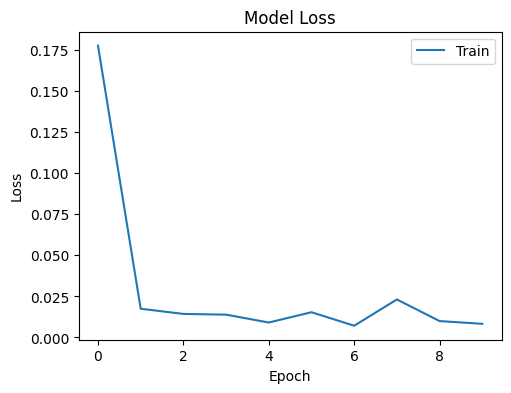

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')



In [61]:
import pickle
import os
from pathlib import Path

# Create models directory if it doesn't exist
models_dir = Path('models')
models_dir.mkdir(exist_ok=True)

print("Saving models and preprocessors...")
print("=" * 60)

# 1. Save LSTM model
model_path = models_dir / 'lstm_model.keras'
model.save(str(model_path))
print(f"✅ Saved LSTM model: {model_path}")

# 2. Save scaler
scaler_path = models_dir / 'scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Saved scaler: {scaler_path}")

# 3. Save template extractor components
# Create a dictionary containing template miner and configuration
template_extractor_data = {
    'template_miner': template_miner,
    'persistence_handler': persistence_handler,
    'config': config
}

template_extractor_path = models_dir / 'template_extractor.pkl'
with open(template_extractor_path, 'wb') as f:
    pickle.dump(template_extractor_data, f)
print(f"✅ Saved template extractor: {template_extractor_path}")

# 4. Save feature engineer components
# Create a dictionary containing all encoders and vectorizers
feature_engineer_data = {
    'encoders': encoders,  # Dictionary with Type, Component, Level encoders
    'label_encoder': label_encoder,
    'tfidf_vectorizer': tfidf_vectorizer,
    'feature_columns': feature_columns,  # List of feature column names
    'is_fitted': True
}

feature_engineer_path = models_dir / 'feature_engineer.pkl'
with open(feature_engineer_path, 'wb') as f:
    pickle.dump(feature_engineer_data, f)
print(f"✅ Saved feature engineer: {feature_engineer_path}")

print("=" * 60)
print("\n✅ All models and preprocessors saved successfully!")
print(f"\nFiles saved to: {models_dir.absolute()}")
print("\nSaved files:")
print(f"  - lstm_model.keras ({os.path.getsize(model_path) / 1024:.2f} KB)")
print(f"  - scaler.pkl ({os.path.getsize(scaler_path) / 1024:.2f} KB)")
print(f"  - template_extractor.pkl ({os.path.getsize(template_extractor_path) / 1024:.2f} KB)")
print(f"  - feature_engineer.pkl ({os.path.getsize(feature_engineer_path) / 1024:.2f} KB)")
print("\nThese files can now be used with the Streamlit application for anomaly detection!")

Saving models and preprocessors...
✅ Saved LSTM model: models\lstm_model.keras
✅ Saved scaler: models\scaler.pkl
✅ Saved template extractor: models\template_extractor.pkl
✅ Saved feature engineer: models\feature_engineer.pkl

✅ All models and preprocessors saved successfully!

Files saved to: d:\AC-Project\log_anomaly_app\bgl\log-anomaly\notebooks\models

Saved files:
  - lstm_model.keras (261.68 KB)
  - scaler.pkl (3.07 KB)
  - template_extractor.pkl (20.97 KB)
  - feature_engineer.pkl (5.31 KB)

These files can now be used with the Streamlit application for anomaly detection!
